# 

# TODO
- reinstall transformers with pytorch-nightly so that can use `mps` device

# Few to No Labels
Concepts Covered:
* Multi-label classification
* Baseline: Naive Bayes cast as a one-vs-rest problem (using `scikit-multilearn`)
* zero-shot classfication: recasting problem as a text entailment problem. 
    * top k vs threshold approach
* Text data augmentation (`nlpaug` library) 
* Using embeddings as a lookup table (FAISS)
    * how many neighbors? what threshold?
* Fine-Tuning a Vanilla Transformer
* Domain Adaptation: Fine-Tuning language model on unlabeled data before training model on labeled data.


**Original Application**: Github issue tagging  
**Potential Application at Nike**: NEoD conversation tagging

## Dataset Preparation


In [209]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from skmultilearn.model_selection import iterative_stratification
import torch
import transformers as tfm

import fewlabels as fl
from fewlabels.preproc import Batch

%load_ext autoreload
%autoreload 2

DATASET_URL = "https://git.io/nlp-with-transformers"
EVAL_FIGURE_PATH = "../images/evaluation.png"

torch.no_deprecation_warning = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_issues = pd.read_json(DATASET_URL, lines=True)

print(f"Dataframe shape: {df_issues.shape}")

# only keep label name (drop id, nodes, ...)
df_issues["labels"] = df_issues.labels.apply(lambda l: [n['name'] for n in l])

# keep main labels and map to simpler lower case labels
LABEL_MAP = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(labels: list[str]) -> list[str]:
    return [LABEL_MAP[label] for label in labels if label in LABEL_MAP]

df_issues["labels"] = df_issues.labels.apply(filter_labels)
all_labels = list(LABEL_MAP.values())

# adding a flag to know whether issue has at least one labeled or not
df_issues["labeled"] = df_issues.labels.apply(len) > 0


# drop duplicates
df_issues["text"] = df_issues.title + "\n\n" + df_issues.body
previous_length = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")

print(f"duplicates dropped: {previous_length - len(df_issues)}")

Dataframe shape: (9930, 26)
duplicates dropped: 187


/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


## Exploratory Data Analysis

In [4]:
# how many issues are labeled/unlabeled?
print(df_issues.labeled
    .map({True: "labeled", False: "unlabeled"})
    .value_counts()
    .to_string()
)

unlabeled    9303
labeled       440


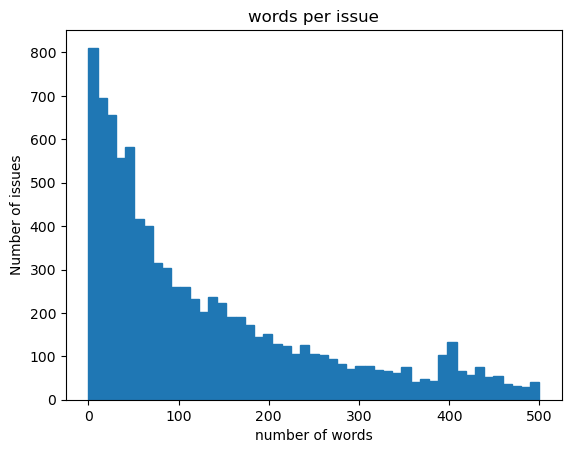

In [5]:
# word counts distribution per issue
(
    df_issues["text"].str.split()
    .apply(len)
    .hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0")
)
plt.title("words per issue")
plt.xlabel("number of words")
plt.ylabel("Number of issues")
plt.show()


### Labels distribution
Across labeled issues

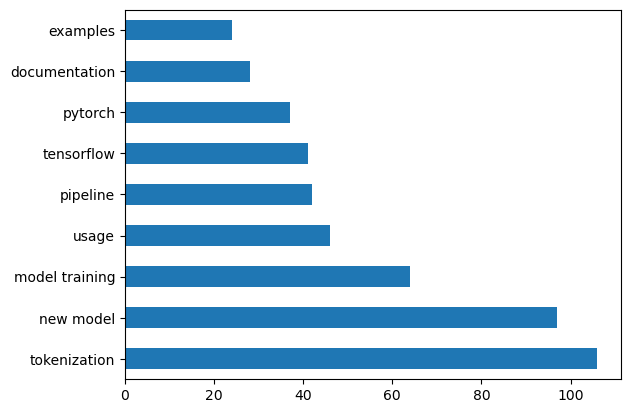

In [6]:

flattened_labels = df_issues.query("labeled == True").labels.sum()

_ = pd.Series(flattened_labels).value_counts().plot.barh()


# Creating a Training Set

In [7]:
# fit a label binarizer on data
mlb = sklearn.preprocessing.MultiLabelBinarizer()

mlb.fit([all_labels])
print(mlb.transform([["tokenization", "pytorch"], ["tensorflow"]]))


[[0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0]]


In [8]:

def balanced_split(df: pd.DataFrame, test_size: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    """allows to create stratified data splits for multilabel datasets."""
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_stratification.iterative_train_test_split(idx, labels, test_size=test_size)

    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df_issues[["text", "labels", "labeled"]].reset_index(drop=True).copy()

df_unsup = df_clean.loc[~df_clean.labeled, ["text","labels"]]
df_sup = df_clean.loc[df_clean.labeled, ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [9]:
ds = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": datasets.Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": datasets.Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": datasets.Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### Creating Training Slices
Goal: test how efficient different strategies are depending on number of labeled samples

In [10]:
# refactored
slice_sizes = [2**x for x in range(3,8)]
train_slices = fl.preproc.create_dataset_slices(ds["train"], slice_sizes, mlb=mlb, seed=0)

print(f"target split size: {slice_sizes}")
print(f"actual split size: {[len(s) for s in train_slices]}")

target split size: [8, 16, 32, 64, 128, 223]
actual split size: [10, 19, 36, 68, 134, 223]


In [11]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

100%|██████████| 10/10 [00:00<00:00, 507.82ba/s]


## Create Evaluator
The `SlicedTrainingEvaluator` fits a pipeline on training slices of various sizes and computes the f1-score (micro / macro) on the test set.

In [12]:
evaluator = fl.eval.SlicedTrainingEvaluator(ds=ds, train_slices=train_slices, mlb=mlb)

In [13]:
import pickle

with open("../data/outputs/f1_score_records.pkl", 'rb') as f:
    evaluator.f1_scores = pickle.load(f)

# Naive Bayes Baseline

In [65]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

strategy = "Naive Bayes"

pipe = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("clf", BinaryRelevance(classifier=MultinomialNB()))
    ])

evaluator.evaluate_pipe_on_slices(pipe, strategy=strategy)



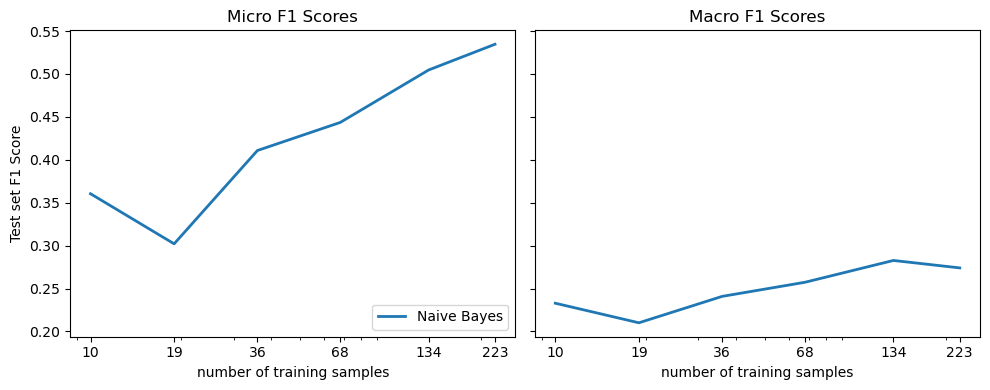

In [66]:
fl.plot.plot_metrics(evaluator, "Naive Bayes")

# Working with No Labeled Data: Zero-Shot Classification
* turn task into an entailment task to figure out whether topics are related by comparing text to a sentence of the form: `"this section was about the topic [MASK]"`
### Fill-Mask Models

In [67]:
FILL_MASK_CKPT = "bert-base-uncased"
pipe = tfm.pipeline("fill-mask", model=FILL_MASK_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
# demo
movie_desc = """Bi Gan follows up his knockout debut, Kaili Blues, 
with this noir-tinged stunner about a lost soul (Jue Huang) on a quest 
to find a missing woman from his past (Wei Tang). Following leads across Guizhou province, 
he crosses paths with a series of colorful characters, among them a prickly hairdresser 
played by Taiwanese superstar Sylvia Chang."""

prompt = "The movie takes place in [MASK]."


def print_zero_shot_output(context: str, prompt: str, targets: list[str] = None):
    output = pipe(movie_desc + prompt, targets=targets)
    for element in output:
        print(f"Token {element['token_str']}:\t{element['score']:.1%}")

print_zero_shot_output(movie_desc, prompt)

Token china:	57.7%
Token beijing:	8.4%
Token shanghai:	6.5%
Token taiwan:	4.5%
Token yunnan:	3.1%


In [84]:
# adding candidate tokens
print_zero_shot_output(movie_desc, prompt, targets=["china", "taiwan", "korea", "japan"])


Token china:	57.7%
Token taiwan:	4.5%
Token japan:	0.3%
Token korea:	0.1%


In [85]:
desc = """DOUBLE THE AF1. DOUBLE THE FUN.
The Nike Air Force 1 Shadow puts a playful twist on a classic b-ball design. Using a layered approach, doubling the branding and exaggerating the midsole, it highlights AF-1 DNA with a bold, new look.
Layered Look
With 2 eyestays, 2 mudguards, 2 back tabs and 2 Swoosh designs, you get a layered look with double the branding.
Lightweight Comfort
A foam midsole and a grooved outsole ensure that the shoe is lightweight, flexible and comfortable.
Iconic Shape
Featuring the same iconic shape as the original Air Force 1, a slightly exaggerated midsole makes the shoe instantly recognizable while also playing with proportions."""
prompt = "this shoe feels [MASK]."

print_zero_shot_output(desc, prompt, targets=["comfortable", "responsive", "springy"])

The specified target token `springy` does not exist in the model vocabulary. Replacing with `spring`.


Token comfortable:	0.7%
Token spring:	0.0%
Token responsive:	0.0%


## Zero-Shot Classification Pipelines
* improving on the fill mask model by allowing for multi-token labels and using a model trained on Natural Language Inference tasks.

In [92]:
pipe = tfm.pipeline("zero-shot-classification")

# test on a sample
sample = ds["train"][0]
output = pipe(sample["text"], all_labels, multi_label=True)
print(f"Labels: {sample['labels']}")
print(f"Text: {output['sequence'][:300]}")
for label, score in zip(output["labels"], output["scores"]):
    print(f"{label:<20}{score:.3f}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Labels: ['new model']
Text: Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded
new model           0.984
examples            0.336
tensorflow          0.307
usage               0.297
pytorch             0.248
documentation       0.245
model training      0.235
tokenization        0.174
pipeline            0.160


In [97]:
# apply pipeline to validation set
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)
    

100%|██████████| 106/106 [11:46<00:00,  6.66s/ex]


## Evaluating best strategy to go from confidence scores to selected labels
Two options to define which labels should be selected:
* define a minimum threshold
* select top k labels with highest scores

In [115]:
# explore the threshold approach
# refactored
from typing import Any

Example = dict[str, list[Any]]


def get_preds_threshold(example: Example, threshold: float):
    return [
        label 
        for label, score in zip(example["predicted_labels"], example["scores"])
        if score >= threshold
        ]


def get_preds_topk(example: Example, topk: int) -> list[str]:
    return [
        example["predicted_labels"][i] for i in range(topk)
    ]

def convert_predictions_to_binary_list(preds: list[str]) -> list[int]:
    return list(np.squeeze(mlb.transform([preds])))

def get_all_preds(example: Example, threshold: float = None, topk: int = None) -> list[int]:
    if threshold:
        preds = get_preds_threshold(example, threshold)
    elif topk: 
        preds = get_preds_topk(example, topk)
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": convert_predictions_to_binary_list(preds)}


from sklearn.metrics import classification_report

def get_clf_report(ds: datasets.Dataset):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])

    return classification_report(y_true, y_pred,
        target_names=mlb.classes_,
        zero_division=0,
        output_dict=True)

# print topk and threshold perf

# refactored
def plot_zero_shot_perf_vs_kwarg(**kwargs: dict[str, list]) -> tuple[list[float]]:
    datasets.disable_progress_bar()
    micros, macros = [], []
    key, values = kwargs.popitem()
    assert key in ("topk", "threshold"), "accepts single argument which should take value `topk` or `threshold`"
    for value in values:
        ds_zero = ds_zero_shot.map(get_all_preds, batched=False, fn_kwargs={key: value})
        clf_report = get_clf_report(ds_zero)
        micros.append(clf_report['micro avg']['f1-score'])
        macros.append(clf_report['macro avg']['f1-score'])

    plt.plot(values, micros, label='Micro F1')
    plt.plot(values, macros, label="Macro F1")
    plt.xlabel(key.capitalize())
    plt.ylabel("F1-score")
    plt.legend(loc='best')
    plt.show()

    return micros, macros

assert sum(get_all_preds(ds_zero_shot[0], topk=3)["pred_label_ids"]) == 3


100%|██████████| 106/106 [00:00<00:00, 16024.37ex/s]


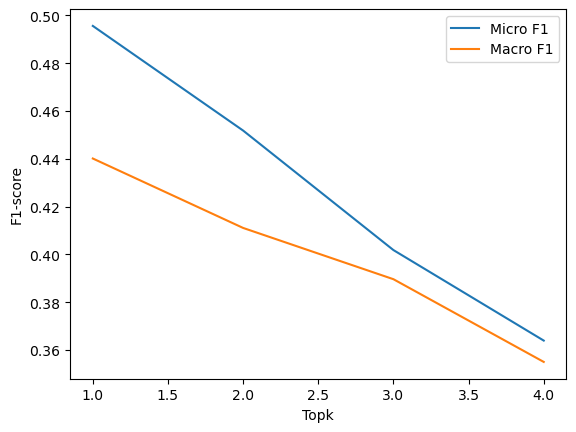

100%|██████████| 106/106 [00:00<00:00, 14372.88ex/s]


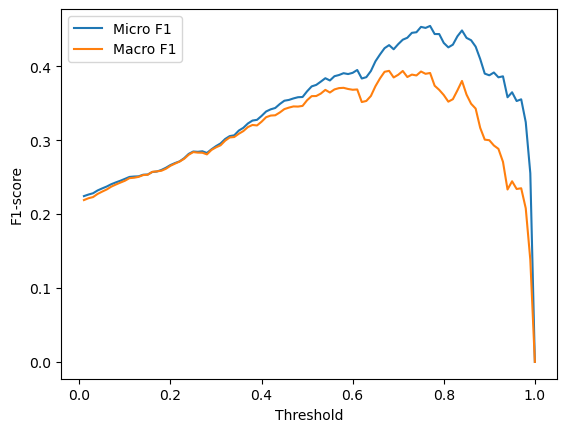

In [132]:
_ = plot_zero_shot_perf_vs_kwarg(topk=[1,2,3,4])

thresholds = np.linspace(0.01,1,100)
micros, macros = plot_zero_shot_perf_vs_kwarg(threshold=thresholds)

In [138]:
# refactored
def get_optimal_threshold(metric: list[float], metric_type: str) -> None:
    best_t, best_metric = thresholds[np.argmax(metric)], np.max(metric)
    print(f"best threshold ({metric_type}): {best_t} with F1-score {best_metric:.2f}")

get_optimal_threshold(micros, "micro")
get_optimal_threshold(macros, "macro")

best threshold (micro): 0.77 with F1-score 0.45
best threshold (macro): 0.68 with F1-score 0.39


Best performing method seems to be **top-1**

### Final Evaluation on test set

In [139]:
ds_zero_shot = ds["test"].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_all_preds, fn_kwargs={"topk": 1})
clf_report = get_clf_report(ds_zero_shot)


100%|██████████| 111/111 [00:00<00:00, 14020.59ex/s]


In [146]:
# record scores across train slices (zero shot == independent of train slices)
y_true = np.array(ds_zero_shot["label_ids"])
y_pred = np.array(ds_zero_shot["pred_label_ids"])

for slice in train_slices:
    evaluator.add_f1_scores(y_true, y_pred, "Zero Shot")

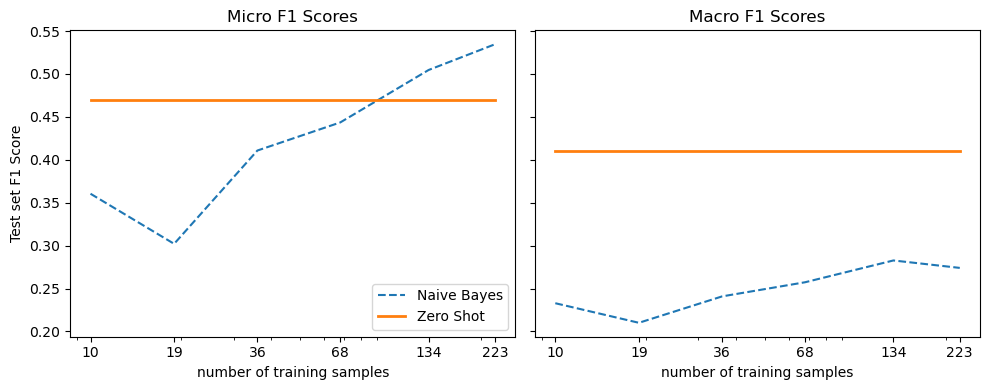

In [147]:
fl.plot.plot_metrics(evaluator, "Zero Shot")

# Working with Few Labels
## Data Augmentation

In [150]:
import nlpaug.augmenter.word as naw

AUGMENTER_CKPT = "distilbert-base-uncased"

aug = naw.ContextualWordEmbsAug(model_path=AUGMENTER_CKPT, 
    device="cpu", 
    action="substitute")

text = "I wonder how well this thing works."
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")


Original text: I wonder how well this thing works.
Augmented text: i question how exactly this thing works.


In [163]:
# refactored
from functools import partial

strategy = "Naive Bayes + Aug"

pipe = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("clf", BinaryRelevance(classifier=MultinomialNB()))
    ])


augment_fcn = partial(
    fl.augment.augment_batch,
    n_transformations=1, # number of augmentations per training example
    augment_fcn=aug.augment, # function to apply to create an augmented example given a single input text.
    )

evaluator.evaluate_pipe_on_slices(pipe, 
    strategy=strategy, 
    augment_fcn=augment_fcn)


100%|██████████| 1/1 [03:38<00:00, 218.18s/ba]


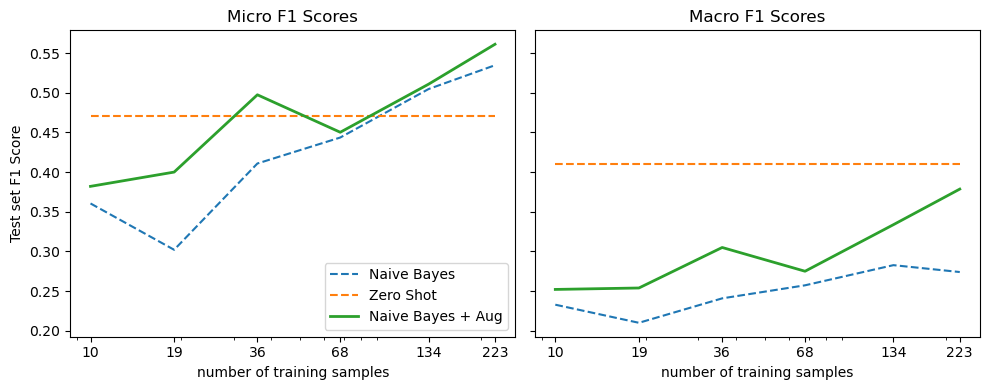

In [14]:
strategy = "Naive Bayes + Aug"
fl.plot.plot_metrics(evaluator, strategy)

## Embeddings as lookup tables
Approach: 
* turn all texts into embeddings
* find nearest `n_neighbors` to the query that are labeled.
* select a label if at least `threshold` neighbors are tagged with that same label.

In [15]:
MODEL_CKPT = "miguelvictor/python-gpt2-large"
tokenizer = tfm.AutoTokenizer.from_pretrained(MODEL_CKPT)
model = tfm.AutoModel.from_pretrained(MODEL_CKPT)

# adding pad token
tokenizer.add_special_tokens({'pad_token': '|pad|'})
model.resize_token_embeddings(len(tokenizer))

# other option: recycle existing special token tokenizer.pad_token = tokenizer.eos_token

text_embedder = fl.knn.TransformerWithMeanPooling(model)

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def get_text_embeddings(batch: Batch) -> Batch:
    inputs = tokenizer(
        batch["text"], 
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128)
    
    with torch.no_grad():
        pooled_embeddings = text_embedder(**inputs)

    return {
        "embeddings": pooled_embeddings.cpu().numpy()}

# verifying that text_embedder works as expected and returns one embedding per input text:
n = 5
assert get_text_embeddings(ds["train"][:n])["embeddings"].shape == (n, model.embed_dim)

### mapping dataset to get embeddings

In [17]:
def add_embeddings_to_dataset(ds: datasets.Dataset) -> datasets.Dataset:
    return ds.map(get_text_embeddings, batched=True, batch_size=16)

embs_train = add_embeddings_to_dataset(ds["train"])
embs_valid = add_embeddings_to_dataset(ds["valid"])
embs_test = add_embeddings_to_dataset(ds["test"])

100%|██████████| 7/7 [00:26<00:00,  3.76s/ba]


### Hyperparameter Search
Hyperparameters to optimize on valid dataset:
* `n_neighbors`: number of nearest neighbors to retrieve labels from
* `threshold`: minimum number of neighbors having a given label to select it for prediction

Bonus: 
* `MODEL_CKPT`: you can easily setup the evaluation pipeline to compare performance with various sentence encoders.

#### First pass: sweep other n_neighbors / threshold pairs and fine best parameters for f1-micro
* 

In [165]:
embs_train.add_faiss_index(column="embeddings")

# test a single tagging strategy
tagger = fl.knn.KNNTagger(k=10, threshold=3)
tagger.fit(embs_train)
tagger.score(embs_valid)

{'micro': 0.5586206896551724, 'macro': 0.497134480050375}

In [167]:
embs_train.drop_index("embeddings")
tmp_train = embs_train.select(train_slice)
tmp_train.add_faiss_index("embeddings")


Dataset({
    features: ['text', 'labels', 'label_ids', 'embeddings'],
    num_rows: 10
})

In [119]:
# refactored
def gridsearch_on_f1_scores(
    train_ds: datasets.Dataset, 
    valid_ds: datasets.Dataset,
    topk: int) -> tuple[np.ndarray, np.ndarray]:
    """returns two arrays: f1-micro and f1-macro scores for 
    all combinations of KNNTagger performance with:
    - k < topk and 
    - threshold < k"""
    topk = min(topk, len(tagger.train_ds))

    micro_scores = np.zeros((topk + 1, topk + 1))
    macro_scores = np.zeros((topk + 1, topk + 1))

    datasets.disable_progress_bar()

    for k in range(1, topk + 1):
        for threshold in range(1, k + 1):

            scores = evaluate_embeddings_knn_approach(
                train_ds, valid_ds, k, threshold,
            )
            micro_scores[k, threshold] = scores["micro"]
            macro_scores[k, threshold] = scores["macro"]

    return micro_scores, macro_scores

def evaluate_embeddings_knn_approach(
    train_ds: datasets.Dataset, 
    valid_ds: datasets.Dataset,
    k: int,
    threshold: int,
    ):
    tagger = fl.knn.KNNTagger(k, threshold)
    tagger.fit(train_ds)
    return tagger.score(valid_ds)


In [120]:
micro_scores, macro_scores = gridsearch_on_f1_scores(embs_train, embs_valid, topk=17)

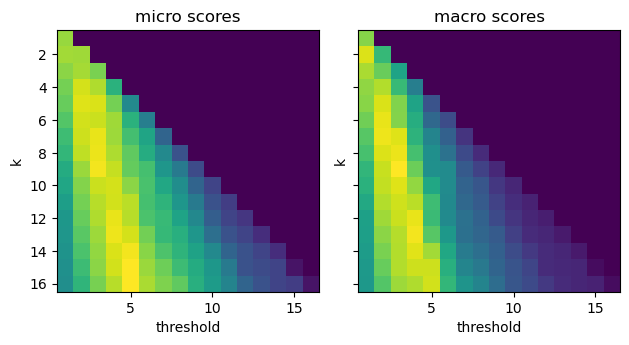

In [122]:
# refactored
fig = fl.plot.plot_gridsearch(micro_scores, macro_scores)

fig.savefig("../images/gridsearch.png")

In [123]:
def get_best_parameters(scores: np.ndarray) -> tuple[int, int]:
    return np.unravel_index(scores.argmax(), scores.shape)

best_k, best_threshold = get_best_parameters(micro_scores)
print(f"Best k: {best_k}, best threshold: {best_threshold}")

Best k: 15, best threshold: 5


#### Replicate Approach on training slices

In [153]:
len(train_slice)

10

In [200]:
# test a single tagging strategy
embs_train.add_faiss_index("embeddings")

tagger = fl.knn.KNNTagger(k=5, threshold=2)
tagger.fit(embs_train)
tagger.score(embs_valid)

{'micro': 0.5791505791505792, 'macro': 0.49283149819396094}

In [201]:
embs_train.drop_index("embeddings")

In [203]:
# refactored: introducing the KNNTagger class that behaves like a classic ML model framework (fit, predict, score methods)
import logging 

strategy = "embedding lookup"

logger = logging.getLogger('embs_eval')
logger.setLevel(logging.INFO)

if logger.hasHandlers():
    logger.handlers.clear()

micros, macros= [], []
best_ks, best_thresholds = [], []

for train_slice in train_slices:

    tmp_train_ds = embs_train.select(train_slice)
    tmp_train_ds.add_faiss_index(column="embeddings")
    
    logger.info(f"hyperparameter search for best params assuming {len(train_slice):,} training examples")
    micro_scores, macro_scores = gridsearch_on_f1_scores(tmp_train_ds, embs_valid, topk=17)
    best_k, best_threshold = get_best_parameters(micro_scores)
    logger.info(f"best k: {best_k}, best threshold: {best_threshold}")

    # evaluate on test set
    logger.info(f"evaluating {strategy} on test set with {len(train_slice):,} training examples")
    tagger = fl.knn.KNNTagger(best_k, best_threshold)
    tagger.fit(tmp_train_ds)
    scores = tagger.score(embs_test)
    logger.info(f"scores: {scores}")
    
    micros.append(scores["micro"])
    macros.append(scores["macro"])
    best_ks.append(best_k)
    best_thresholds.append(best_threshold)

evaluator.f1_scores["micro"][strategy] = micros
evaluator.f1_scores["macro"][strategy] = macros

INFO:embs_eval:hyperparameter search for best params assuming 10 training examples
INFO:embs_eval:best k: 10, best threshold: 2
INFO:embs_eval:evaluating embedding lookup on test set with 10 training examples
INFO:embs_eval:scores: {'micro': 0.2898550724637681, 'macro': 0.08167973326124178}
INFO:embs_eval:hyperparameter search for best params assuming 19 training examples
INFO:embs_eval:best k: 6, best threshold: 2
INFO:embs_eval:evaluating embedding lookup on test set with 19 training examples
INFO:embs_eval:scores: {'micro': 0.36721311475409835, 'macro': 0.2364015225881665}
INFO:embs_eval:hyperparameter search for best params assuming 36 training examples
INFO:embs_eval:best k: 13, best threshold: 3
INFO:embs_eval:evaluating embedding lookup on test set with 36 training examples
INFO:embs_eval:scores: {'micro': 0.4316109422492402, 'macro': 0.27436131670002634}
INFO:embs_eval:hyperparameter search for best params assuming 68 training examples
INFO:embs_eval:best k: 3, best threshold: 

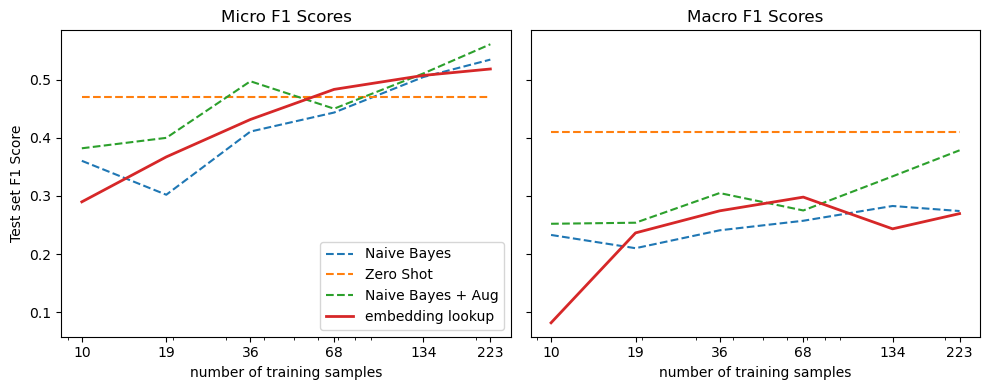

In [210]:
fig = fl.plot.plot_metrics(evaluator, strategy)
fig.savefig(EVAL_FIGURE_PATH)

#### How does the best parameter sets evolves as training size increases?

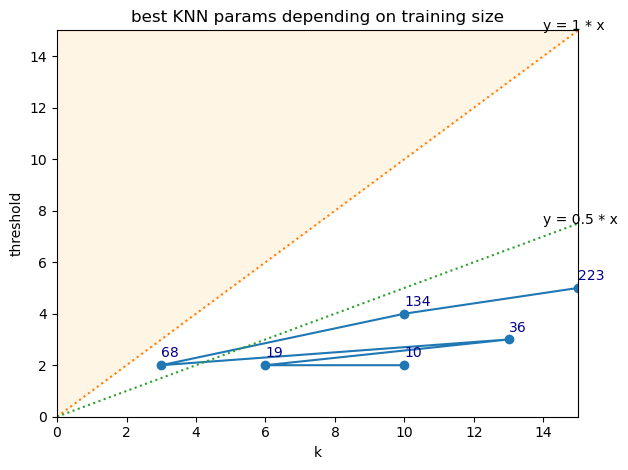

In [267]:
# refactored
def plot_best_params(best_ks: list[int], best_thresholds: list[int], annotations: list) -> None:
    plt.plot(best_ks, best_thresholds, marker='o')
    plt.xlabel("k")
    plt.ylabel("threshold")
    plt.xlim([0,15])
    plt.ylim([0,15])

    annotate(best_ks, best_thresholds, annotations)

    x = np.array([0, 15])

    for factor in [1, .5]:
        plot_line_references(15, factor)

    plt.title("best KNN params depending on training size")
    plt.fill_between(x, x, [15,15], color="orange", alpha=.1)
    plt.tight_layout()
    plt.show()

def annotate(xs, ys, text):
    for x, y, s in zip(xs, ys, text):
        plt.text(x, y+.3, s, c="darkblue")

def plot_line_references(xlim, factor):
    plt.plot([0, xlim], [0, xlim * factor], ':')
    plt.text(xlim -1, xlim * factor, f"y = {factor} * x")

plot_best_params(best_ks, best_thresholds, [len(slice) for slice in train_slices])

Doesn't seem like the trend is very stable..., except for the fact that `threshold` tends to stay under k / 2.

# Vanilla Transformer

In [245]:
MODEL_CKPT = "bert-base-uncased"

tokenizer = tfm.AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True, remove_columns=["labels", "text"])

In [247]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda example: {"label_ids_f": example["label_ids"].to(torch.float)}, remove_columns="label_ids")
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

In [301]:
# refactored
STRATEGY = 'Fine-tune (vanilla) v2'
PATH_TO_TRAINING_CONFIG = "../config/training_args_default.json"
OUTPUT_DIR = "../models/bert-base-tagger-tmp/"

runner = fl.train.SlicedTrainingRunner(
    model_ckpt=MODEL_CKPT,
    dataset=ds_enc,
    num_labels=len(all_labels),
    path_to_training_config=PATH_TO_TRAINING_CONFIG,
    output_dir=OUTPUT_DIR,
)

evaluator = runner.evaluate_tfm_model_on_all_slices(
    strategy=strategy,
    evaluator=evaluator,
    train_slices=train_slices[:2],
    )

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.684, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.635289192199707, 'eval_micro f1': 0.2670157068062827, 'eval_macro f1': 0.10343014900537024, 'eval_runtime': 3.4786, 'eval_samples_per_second': 30.472, 'eval_steps_per_second': 1.15, 'epoch': 1.0}
{'loss': 0.6097, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5919589400291443, 'eval_micro f1': 0.24773413897280966, 'eval_macro f1': 0.11186029334177482, 'eval_runtime': 3.4243, 'eval_samples_per_second': 30.955, 'eval_steps_per_second': 1.168, 'epoch': 2.0}
{'train_runtime': 15.451, 'train_samples_per_second': 1.294, 'train_steps_per_second': 0.388, 'train_loss': 0.6468483209609985, 'epoch': 2.0}


/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6254, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5635040402412415, 'eval_micro f1': 0.1409691629955947, 'eval_macro f1': 0.029143897996357013, 'eval_runtime': 3.5337, 'eval_samples_per_second': 29.997, 'eval_steps_per_second': 1.132, 'epoch': 1.0}
{'loss': 0.5147, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4960343837738037, 'eval_micro f1': 0.016260162601626015, 'eval_macro f1': 0.011695906432748537, 'eval_runtime': 3.57, 'eval_samples_per_second': 29.692, 'eval_steps_per_second': 1.12, 'epoch': 2.0}
{'train_runtime': 19.2106, 'train_samples_per_second': 1.978, 'train_steps_per_second': 0.521, 'train_loss': 0.5700319290161133, 'epoch': 2.0}


In [302]:
evaluator.f1_scores['micro'].pop(strategy)
evaluator.f1_scores['macro'].pop(strategy)

[0.12977501801031213, 0.02799650043744532]

In [258]:
# refactored
STRATEGY = 'Fine-tune (vanilla)'
PATH_TO_TRAINING_CONFIG = "../config/training_args_default.json"
OUTPUT_DIR = "../models/bert-base-tagger/"

runner = fl.train.SlicedTrainingRunner(
    model_ckpt=MODEL_CKPT,
    dataset=ds_enc,
    num_labels=len(all_labels),
    path_to_training_config=PATH_TO_TRAINING_CONFIG,
    output_dir=OUTPUT_DIR,
)

evaluator = runner.evaluate_tfm_model_on_all_slices(
    strategy=strategy,
    evaluator=evaluator,
    train_slices=train_slices,
    )

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.7289, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6809362173080444, 'eval_micro f1': 0.2011834319526627, 'eval_macro f1': 0.12566895497216912, 'eval_runtime': 3.453, 'eval_samples_per_second': 30.698, 'eval_steps_per_second': 1.158, 'epoch': 1.0}
{'loss': 0.6498, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.644482433795929, 'eval_micro f1': 0.21893491124260359, 'eval_macro f1': 0.07557598172754991, 'eval_runtime': 3.4281, 'eval_samples_per_second': 30.921, 'eval_steps_per_second': 1.167, 'epoch': 2.0}
{'loss': 0.616, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.6029537320137024, 'eval_micro f1': 0.2356687898089172, 'eval_macro f1': 0.07946127312440468, 'eval_runtime': 3.6445, 'eval_samples_per_second': 29.085, 'eval_steps_per_second': 1.098, 'epoch': 3.0}
{'loss': 0.5848, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.5502384305000305, 'eval_micro f1': 0.2434782608695652, 'eval_macro f1': 0.05818467737972382, 'eval_runtime': 3.4667, 'eval_s

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.7035, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6391443014144897, 'eval_micro f1': 0.21652421652421655, 'eval_macro f1': 0.08412299027455845, 'eval_runtime': 3.5286, 'eval_samples_per_second': 30.04, 'eval_steps_per_second': 1.134, 'epoch': 1.0}
{'loss': 0.5942, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.6029963493347168, 'eval_micro f1': 0.0679611650485437, 'eval_macro f1': 0.026555881394591068, 'eval_runtime': 3.4833, 'eval_samples_per_second': 30.431, 'eval_steps_per_second': 1.148, 'epoch': 2.0}
{'loss': 0.5292, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.48361513018608093, 'eval_micro f1': 0.2048192771084337, 'eval_macro f1': 0.052469135802469126, 'eval_runtime': 3.4204, 'eval_samples_per_second': 30.991, 'eval_steps_per_second': 1.169, 'epoch': 3.0}
{'loss': 0.4424, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4296756982803345, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.5014, 'eval_samples_per_second': 30.273

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6305, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5206137895584106, 'eval_micro f1': 0.015748031496062992, 'eval_macro f1': 0.014814814814814815, 'eval_runtime': 3.4078, 'eval_samples_per_second': 31.105, 'eval_steps_per_second': 1.174, 'epoch': 1.0}
{'loss': 0.4615, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.42700275778770447, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4022, 'eval_samples_per_second': 31.156, 'eval_steps_per_second': 1.176, 'epoch': 2.0}
{'loss': 0.3892, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.39026781916618347, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4466, 'eval_samples_per_second': 30.755, 'eval_steps_per_second': 1.161, 'epoch': 3.0}
{'loss': 0.3447, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.36889129877090454, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.5845, 'eval_samples_per_second': 29.572, 'eval_steps_per_second': 1.116, 'epoch': 4.0}
{'loss': 0.

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5202, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4270191788673401, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4977, 'eval_samples_per_second': 30.306, 'eval_steps_per_second': 1.144, 'epoch': 1.0}
{'loss': 0.3886, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3706212639808655, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4498, 'eval_samples_per_second': 30.727, 'eval_steps_per_second': 1.159, 'epoch': 2.0}
{'loss': 0.3517, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3613855838775635, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.5677, 'eval_samples_per_second': 29.711, 'eval_steps_per_second': 1.121, 'epoch': 3.0}
{'loss': 0.3325, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3506079316139221, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.5025, 'eval_samples_per_second': 30.264, 'eval_steps_per_second': 1.142, 'epoch': 4.0}
{'loss': 0.3171, 'learning_rate': 3e-05, 'epoch'

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4912, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.38951560854911804, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4176, 'eval_samples_per_second': 31.016, 'eval_steps_per_second': 1.17, 'epoch': 1.0}
{'loss': 0.3597, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.35875168442726135, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4275, 'eval_samples_per_second': 30.926, 'eval_steps_per_second': 1.167, 'epoch': 2.0}
{'loss': 0.3299, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3345937430858612, 'eval_micro f1': 0.2777777777777778, 'eval_macro f1': 0.0925925925925926, 'eval_runtime': 3.447, 'eval_samples_per_second': 30.752, 'eval_steps_per_second': 1.16, 'epoch': 3.0}
{'loss': 0.2992, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.30988627672195435, 'eval_micro f1': 0.2222222222222222, 'eval_macro f1': 0.09340374857616236, 'eval_runtime': 3.4738, 'eval_samples_per_second': 30.514, 'eval_steps_per_second': 1.151, '

/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4408, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.37186554074287415, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4745, 'eval_samples_per_second': 30.508, 'eval_steps_per_second': 1.151, 'epoch': 1.0}
{'loss': 0.3393, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.33148086071014404, 'eval_micro f1': 0.15267175572519082, 'eval_macro f1': 0.0634920634920635, 'eval_runtime': 3.4889, 'eval_samples_per_second': 30.382, 'eval_steps_per_second': 1.146, 'epoch': 2.0}
{'loss': 0.3017, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3044753074645996, 'eval_micro f1': 0.2836879432624113, 'eval_macro f1': 0.10834892631203778, 'eval_runtime': 3.4562, 'eval_samples_per_second': 30.669, 'eval_steps_per_second': 1.157, 'epoch': 3.0}
{'loss': 0.2644, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.2633124589920044, 'eval_micro f1': 0.48148148148148157, 'eval_macro f1': 0.1862473018809744, 'eval_runtime': 3.4796, 'eval_samples_per_second': 30.464,

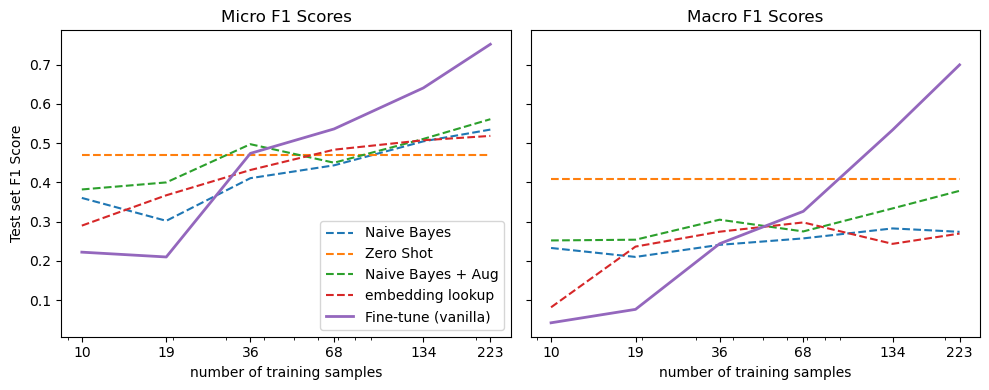

In [261]:
fig = fl.plot.plot_metrics(evaluator, strategy)
fig.savefig(EVAL_FIGURE_PATH)

We can see above that a fine-tuned model with about 100 training examples starts to outperform other methods explored so far.

# Leverage unlabeled data to do Domain Adaptation
## 1. Masked Language Modeling (MLM) on in-domain data

In [308]:
def tokenize(batch):
    return tokenizer(
        batch["text"], 
        truncation=True, 
        max_length=128,
        return_special_tokens_mask=True,
    )

ds_mlm = ds.map(tokenize, batched=True, remove_columns=["labels", "text", "label_ids"])

In [309]:
# collator allows to do random masking on the fly, and define labels
data_collator = tfm.DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [320]:
data_collator.return_tensors = "np"
inputs = tokenizer("let's have a check at how this works!", return_tensors="np")

def get_input_ids(data):
    return data["input_ids"][0]

outputs = data_collator([{"input_ids": get_input_ids(inputs)}])



display(pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(get_input_ids(inputs)),
    "Masked tokens": tokenizer.convert_ids_to_tokens(get_input_ids(outputs)),
    "Original input ids": get_input_ids(inputs),
    "Masked input ids": get_input_ids(outputs),
    "Labels": outputs["labels"][0],
}).T)

data_collator.return_tensors = "pt"

,0,1,2,3,4,5,6,7,8,9,10,11,12
Original tokens,[CLS],let,',s,have,a,check,at,how,this,works,!,[SEP]
Masked tokens,[CLS],let,',s,[MASK],[MASK],check,at,how,this,works,!,[SEP]
Original input ids,101,2292,1005,1055,2031,1037,4638,2012,2129,2023,2573,999,102
Masked input ids,101,2292,1005,1055,103,103,4638,2012,2129,2023,2573,999,102
Labels,-100,-100,-100,-100,2031,1037,-100,-100,-100,-100,-100,-100,-100


In [324]:
OUTPUT_DIR = f"../models/{MODEL_CKPT}-github-tfm"

training_args = tfm.TrainingArguments(
    output_dir = OUTPUT_DIR,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="no",
    push_to_hub=False,
    num_train_epochs=16,
    log_level="error",
    report_to="none",
    optim="adamw_torch",
)

trainer = tfm.Trainer(
    model=tfm.AutoModelForMaskedLM.from_pretrained(MODEL_CKPT),
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds_mlm["unsup"],
    eval_dataset=ds_mlm["train"],
)

trainer.train()

{'loss': 2.0966, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.5854653120040894, 'eval_runtime': 8.4764, 'eval_samples_per_second': 26.308, 'eval_steps_per_second': 0.826, 'epoch': 1.0}
{'loss': 1.633, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.5185171365737915, 'eval_runtime': 8.2969, 'eval_samples_per_second': 26.878, 'eval_steps_per_second': 0.844, 'epoch': 2.0}
{'loss': 1.4937, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.3659731149673462, 'eval_runtime': 8.2798, 'eval_samples_per_second': 26.933, 'eval_steps_per_second': 0.845, 'epoch': 3.0}
{'loss': 1.3953, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.3466957807540894, 'eval_runtime': 8.3799, 'eval_samples_per_second': 26.611, 'eval_steps_per_second': 0.835, 'epoch': 4.0}
{'loss': 1.3385, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.3102307319641113, 'eval_runtime': 8.5131, 'eval_samples_per_second': 26.195, 'eval_steps_per_second': 0.82

TrainOutput(global_step=4656, training_loss=1.2843812568900512, metrics={'train_runtime': 29288.1043, 'train_samples_per_second': 5.082, 'train_steps_per_second': 0.159, 'train_loss': 1.2843812568900512, 'epoch': 16.0})

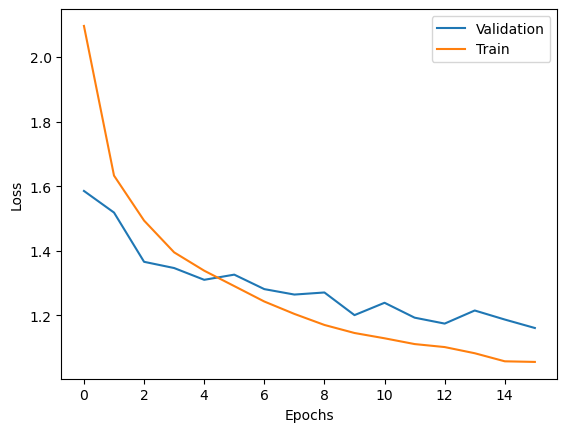

In [325]:
# refactored
fl.plot.plot_trainer_loss(trainer.state.log_history)

In [329]:
trainer.save_model()

## Fine-tuning clasification task on Domain Adapted Model

In [326]:
with open("../data/outputs/f1_score_records.pkl", 'wb') as f:
     pickle.dump(evaluator.f1_scores, f)

In [331]:
# refactored
MODEL_CKPT = "../models/bert-base-uncased-github-tfm/"
STRATEGY = 'Fine-tune (Domain Adapt)'
PATH_TO_TRAINING_CONFIG = "../config/training_args_default.json"
OUTPUT_DIR = "../models/bert-github-tfm-tagger/"

runner = fl.train.SlicedTrainingRunner(
    model_ckpt=MODEL_CKPT,
    dataset=ds_enc,
    num_labels=len(all_labels),
    path_to_training_config=PATH_TO_TRAINING_CONFIG,
    output_dir=OUTPUT_DIR,
)

evaluator = runner.evaluate_tfm_model_on_all_slices(
    strategy=STRATEGY,
    evaluator=evaluator,
    train_slices=train_slices,
    )   

{'loss': 0.6208, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5395870804786682, 'eval_micro f1': 0.016129032258064516, 'eval_macro f1': 0.007936507936507936, 'eval_runtime': 3.566, 'eval_samples_per_second': 29.725, 'eval_steps_per_second': 1.122, 'epoch': 1.0}
{'loss': 0.4814, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4668678641319275, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4154, 'eval_samples_per_second': 31.036, 'eval_steps_per_second': 1.171, 'epoch': 2.0}
{'loss': 0.4119, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4241443872451782, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.4232, 'eval_samples_per_second': 30.965, 'eval_steps_per_second': 1.169, 'epoch': 3.0}
{'loss': 0.371, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.39944007992744446, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 3.519, 'eval_samples_per_second': 30.122, 'eval_steps_per_second': 1.137, 'epoch': 4.0}
{'loss': 0.3416,

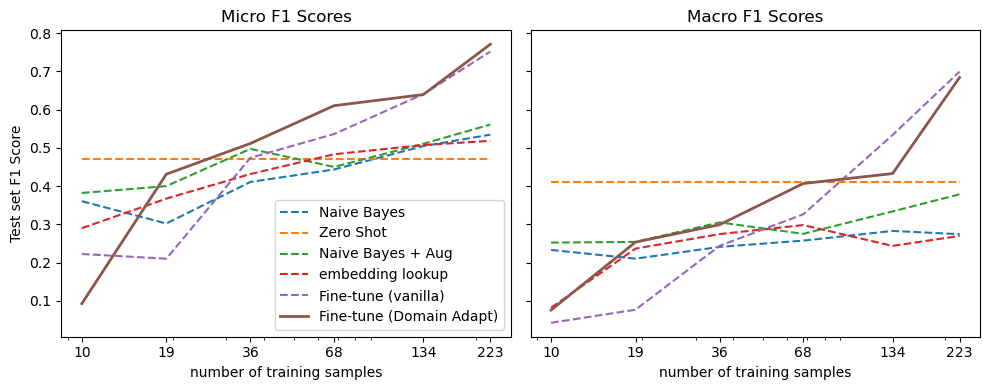

In [334]:
_ = fl.plot.plot_metrics(evaluator, STRATEGY)
fig.savefig(EVAL_FIGURE_PATH)

## Conclusion
Domain Adaptation seems to help a bit when training data is extremely limited (<100 examples). it's added value diminishes as training size increases.